In [1]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import yfinance as yf
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
# For PLotting we will use these library

import matplotlib.pyplot as plt

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [14]:
# Step 1: Data cleaning
data = yf.download(tickers='BTC-usd', period='max', interval='1d')
data.dropna(inplace=True)
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...
2023-02-17,23621.283203,24924.041016,23460.755859,24565.601562,24565.601562,41358451255
2023-02-18,24565.296875,24798.835938,24468.373047,24641.277344,24641.277344,19625427158
2023-02-19,24640.027344,25093.054688,24327.642578,24327.642578,24327.642578,25555105670


In [15]:
# Step 2: Feature engineering
data['RSI']       = ta.rsi(data.Close, length=15)
data['EMA_short'] = ta.ema(data.Close, length=20)
data['EMA_long']  = ta.ema(data.Close, length=100)
data.dropna(inplace=True)
data.reset_index(inplace = True)
data.drop([ 'Close'], axis=1, inplace=True)
# Setting the index
data.set_index('Date', inplace=True)

# Dropping any NaNs
data.dropna(inplace=True)

data.info()
data.tail(10)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2981 entries, 2014-12-25 to 2023-02-22
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2981 non-null   float64
 1   High       2981 non-null   float64
 2   Low        2981 non-null   float64
 3   Adj Close  2981 non-null   float64
 4   Volume     2981 non-null   int64  
 5   RSI        2981 non-null   float64
 6   EMA_short  2981 non-null   float64
 7   EMA_long   2981 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 209.6 KB


,Open,High,Low,Adj Close,Volume,RSI,EMA_short,EMA_long
Date,,,,,,,,
2023-02-12,21870.902344,22060.994141,21682.828125,21788.203125,17821046406,48.538550,22317.339823,20103.186881
2023-02-13,21787.000000,21898.414062,21460.087891,21808.101562,23918742607,48.750732,22268.840941,20136.947568
2023-02-14,21801.822266,22293.140625,21632.394531,22220.804688,26792596581,53.052268,22264.266059,20178.212065
2023-02-15,22220.585938,24307.841797,22082.769531,24307.841797,32483312909,67.728410,22458.892320,20259.986911
2023-02-16,24307.349609,25134.117188,23602.523438,23623.474609,39316664596,61.025952,22569.804919,20326.590628
2023-02-17,23621.283203,24924.041016,23460.755859,24565.601562,41358451255,65.990173,22759.880790,20410.531439
2023-02-18,24565.296875,24798.835938,24468.373047,24641.277344,19625427158,66.358943,22939.061414,20494.308585
2023-02-19,24640.027344,25093.054688,24327.642578,24327.642578,25555105670,63.310636,23071.307239,20570.216189
2023-02-20,24336.623047,25020.458984,23927.910156,24829.148438,28987376573,65.987423,23238.720687,20654.551481


In [16]:
"""# Split data into training and testing sets using TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(data):
    train_data = data.iloc[train_index]
    test_data = data.iloc[test_index]"""
    
# Split the data into training and test sets
train_data  = data[:int(len(data)*0.8)]
test_data = data[int(len(data)*0.8):]


In [17]:
train_x = train_data.index
train_y = train_data['Adj Close']
test_x = test_data.index
test_y = test_data['Adj Close']

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_x, y=train_y, name='Train Data'))
fig.add_trace(go.Scatter(x=test_x, y=test_y, name='Test Data'))

fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Price',
    title ='Train and Test Bitcoin Data',
    font_size=15,
    font_color='black',
    legend_title_text=' Parameters'
)

fig.show()

In [18]:
print ('Train shape',train_data.shape)
print ('test shape', test_data.shape)

Train shape (2384, 8)
test shape (597, 8)


In [19]:
train_df= train_data.copy()
test_df= test_data.copy()

In [20]:

scaler = MinMaxScaler()
train_data= scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)



In [21]:
def create_sequences1(data, sequence_length):
    X = []
    y = []
    for i in range(len(data) - sequence_length ):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

sequence_length = 5
X_train, y_train = create_sequences1(train_data, sequence_length)
X_test, y_test = create_sequences1(test_data, sequence_length)
print("X_train" , X_train.shape)
print("y_train", y_train.shape)
print ("x_test",X_test.shape)
print ("y_test",y_test.shape)

X_train (2379, 5, 8)
y_train (2379, 8)
x_test (592, 5, 8)
y_test (592, 8)


In [9]:
# Prepare the training data
#X_train = np.array([train_data[i:i+5] for i in range(len(train_data)-5)])
#y_train = train_data[1:]
#y_train = np.array([train_data.iloc[i+1] for i in range(len(train_data)-1)])
# Prepare the testing data 
#X_test = np.array([test_data[i:i+5] for i in range(len(test_data)-5)])
#y_test = test_data[1:]
#y_test = np.array([test_data.iloc[i+1] for i in range(len(test_data)-1)])

In [10]:
print('X_train',X_train.shape)
print('y_train',y_train.shape)
print('X_test', X_test.shape)
print('Y_test', y_test.shape) 

X_train (2379, 5, 8)
y_train (2383, 8)
X_test (592, 5, 8)
Y_test (596, 8)


In [10]:
# Normalize the data
"""mean = train_data.mean()
std = train_data.std()
train_data = (train_data - mean) / std
test_data = (test_data - mean) / std"""


'mean = train_data.mean()\nstd = train_data.std()\ntrain_data = (train_data - mean) / std\ntest_data = (test_data - mean) / std'

In [22]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True, activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(75, return_sequences=True, activation='relu'))
model.add(Dropout(0.25))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(8, activation='linear'))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy', 'mean_absolute_error'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 5, 100)            43600     
                                                                 
 dropout_4 (Dropout)         (None, 5, 100)            0         
                                                                 
 lstm_5 (LSTM)               (None, 5, 100)            80400     
                                                                 
 dropout_5 (Dropout)         (None, 5, 100)            0         
                                                                 
 lstm_6 (LSTM)               (None, 5, 75)             52800     
                                                                 
 dropout_6 (Dropout)         (None, 5, 75)             0         
                                                                 
 lstm_7 (LSTM)               (None, 50)               

In [23]:
# Fit the model to the training data
history = model.fit(X_train, y_train, epochs=1000, batch_size=32)

Epoch 1/1000
75/75 [==============================] - 14s 34ms/step - loss: 0.0334 - accuracy: 0.9172 - mean_absolute_error: 0.1148
Epoch 2/1000
75/75 [==============================] - 3s 34ms/step - loss: 0.0113 - accuracy: 0.9264 - mean_absolute_error: 0.0686
Epoch 3/1000
75/75 [==============================] - 2s 31ms/step - loss: 0.0076 - accuracy: 0.9273 - mean_absolute_error: 0.0548
Epoch 4/1000
75/75 [==============================] - 2s 33ms/step - loss: 0.0068 - accuracy: 0.9336 - mean_absolute_error: 0.0504
Epoch 5/1000
75/75 [==============================] - 2s 29ms/step - loss: 0.0062 - accuracy: 0.9323 - mean_absolute_error: 0.0475
Epoch 6/1000
75/75 [==============================] - 2s 27ms/step - loss: 0.0054 - accuracy: 0.9378 - mean_absolute_error: 0.0452
Epoch 7/1000
75/75 [==============================] - 2s 29ms/step - loss: 0.0056 - accuracy: 0.9378 - mean_absolute_error: 0.0444
Epoch 8/1000
75/75 [==============================] - 2s 28ms/step - loss: 0.0050 

In [24]:
def visualize_training_results(results):
    """
    Plots the loss and accuracy for the training and testing data
    """
    history = results.history

    plt.figure(figsize=(16,5))
 
    plt.plot(history['mean_absolute_error'])
    plt.legend([ 'mean_absolute_error'])
    plt.title('mean_absolute_error')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    plt.figure(figsize=(16,5))
 
    plt.plot(history['loss'])
    plt.legend([ 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(16,5))

    plt.plot(history['accuracy'])
    plt.legend([ 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()




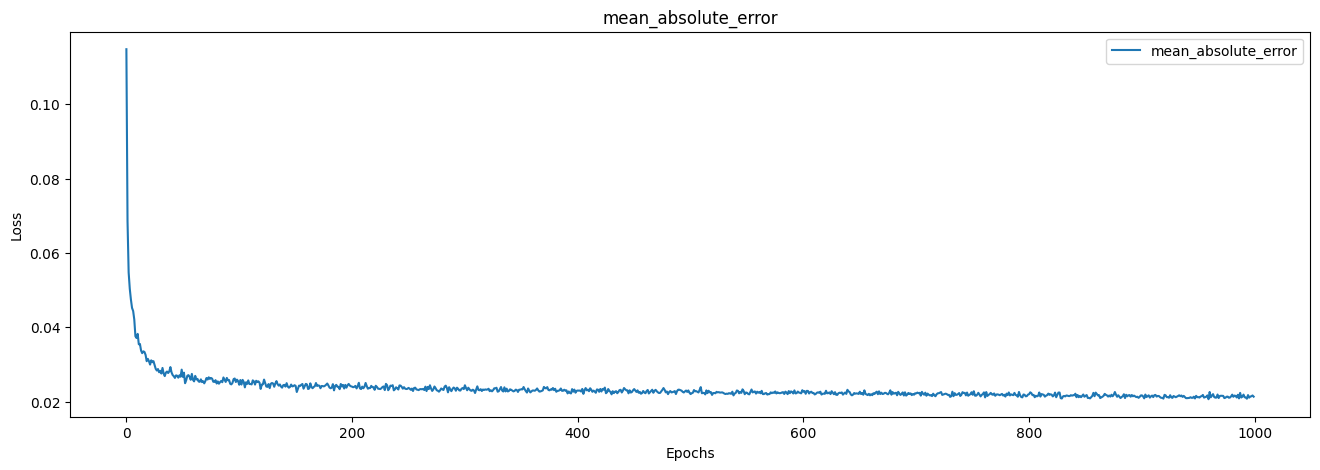

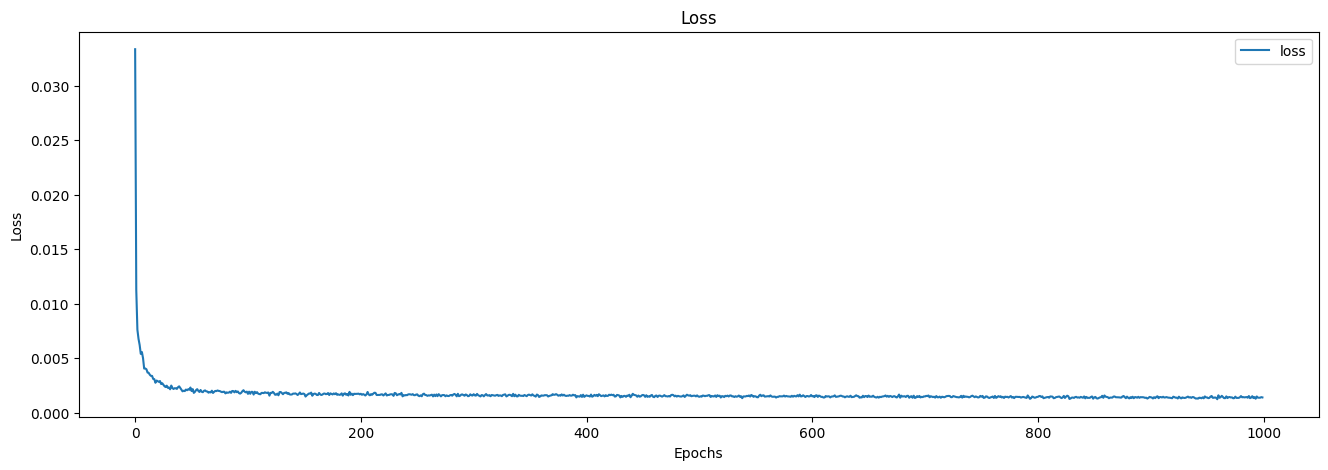

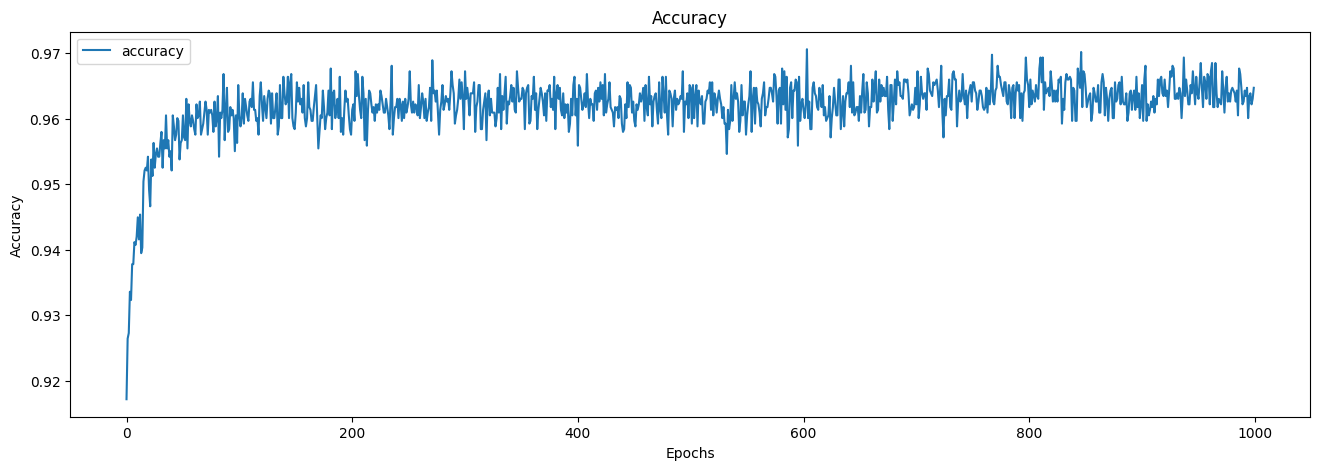

In [25]:
visualize_training_results(history)

In [26]:
mean_squared_error,accuracy ,mean_absolute_error = model.evaluate(X_test, y_test)


19/19 [==============================] - 4s 17ms/step - loss: 0.0039 - accuracy: 0.8345 - mean_absolute_error: 0.0493


In [27]:
# Make predictions on the test data
y_pred = model.predict(X_test)

19/19 [==============================] - 3s 15ms/step


In [17]:
print('y_pred',y_pred.shape)
print('y_test',y_test.shape)

y_pred (596, 8)
y_test (596, 8)


In [33]:
# convert to original data 
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

In [34]:
y_test


array([[33811.2421875 , 34209.0703125 , 33116.01171875, ...,
           44.91042996, 34383.48843699, 40734.94469928],
       [33509.078125  , 34584.703125  , 33346.73828125, ...,
           47.38728374, 34369.8407287 , 40606.33564583],
       [34254.015625  , 34592.15625   , 32697.30859375, ...,
           44.18057982, 34254.22234085, 40458.80123019],
       ...,
       [24640.02734375, 25093.0546875 , 24327.64257812, ...,
           63.31063638, 23071.30723919, 20570.21618898],
       [24336.62304688, 25020.45898438, 23927.91015625, ...,
           65.98742323, 23238.72068665, 20654.55148103],
       [24449.48632812, 24469.04101562, 23645.65234375, ...,
           57.90187636, 23304.86689357, 20719.4763202 ]])

In [35]:
y_pred

array([[33213.11    , 34259.645   , 31794.713   , ...,    44.219185,
        35444.25    , 39549.406   ],
       [32936.895   , 33976.56    , 31524.793   , ...,    44.192608,
        35176.363   , 39267.125   ],
       [33559.688   , 34605.75    , 32162.854   , ...,    45.257088,
        35550.594   , 39384.184   ],
       ...,
       [25395.697   , 26268.21    , 24515.414   , ...,    69.029884,
        23196.455   , 18781.46    ],
       [23901.555   , 24740.535   , 23036.848   , ...,    68.23281 ,
        21909.87    , 17899.086   ],
       [25553.727   , 26440.094   , 24650.031   , ...,    68.76122 ,
        23368.795   , 18906.465   ]], dtype=float32)

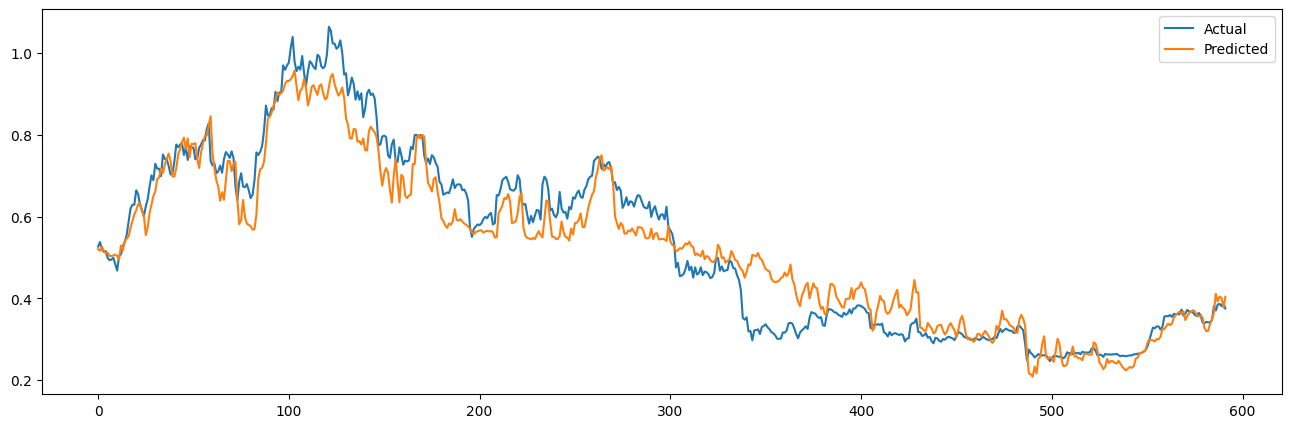

In [28]:
# Combine the two dataframes and plot the results

plt.figure(figsize=(16,5))
plt.plot(y_test[:,3], label="Actual")
plt.plot(y_pred[:,3], label="Predicted")
plt.legend()
plt.show()

In [29]:
# Compute the evaluation metrics
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
mse = np.mean((y_test - y_pred)**2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_test - y_pred))

print(f'MAPE: {mape:.2f}%')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')

MAPE: 16.42%
MSE: 0.00
RMSE: 0.06
MAE: 0.05


In [30]:
# Calculate the MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print("MAPE:", mape)

# Calculate the RMSE (Root Mean Squared Error)
rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
print("RMSE:", rmse)

# Calculate the MSE (Mean Squared Error)
mse = np.mean((y_test - y_pred) ** 2)
print("MSE:", mse)

# Calculate the MAE (Mean Absolute Error)
mae = np.mean(np.abs(y_test- y_pred))
print("MAE:", mae)


MAPE: 16.41658619411987
RMSE: 0.06253398998726205
MSE: 0.00391049990372699
MAE: 0.04925487464277282


In [24]:
print( X_test.shape)

(596, 1, 8)


In [31]:

# Use the model to predict the next 10 days of Bitcoin prices
last_five_days = np.array([test_data[-30:]])
predictions = []
for i in range(10):
    prediction = model.predict(last_five_days)[0]
    predictions.append(prediction)
    last_five_days = np.append(last_five_days[:,1:,:],  [prediction[np.newaxis,:]], axis=1)


1/1 [==============================] - 0s 166ms/step


In [25]:
# Convert the predictions back to actual Bitcoin prices
predictions = np.array(predictions) * std.values + mean.values


NameError: name 'std' is not defined

In [ ]:
test_data= np.array(test_data) * std.values + mean.values

test_data

In [27]:
predictions=  scaler.inverse_transform(predictions)


In [28]:
predictions

array([[1.09961626e+04, 1.13115229e+04, 1.06252375e+04, 1.10520864e+04,
        2.50036518e+10, 6.81134556e+01, 8.75704581e+03, 6.53741578e+03],
       [9.72006856e+03, 9.97207057e+03, 9.43724313e+03, 9.76381589e+03,
        2.19188862e+10, 6.47506408e+01, 7.83818081e+03, 5.83819060e+03],
       [8.13433047e+03, 8.32255421e+03, 7.93410312e+03, 8.16668021e+03,
        1.88805708e+10, 6.18652877e+01, 6.60407758e+03, 4.98878174e+03],
       [7.00524118e+03, 7.14518674e+03, 6.86763155e+03, 7.02810438e+03,
        1.65712238e+10, 5.96265072e+01, 5.73940130e+03, 4.38543543e+03],
       [6.27532833e+03, 6.37997655e+03, 6.18357684e+03, 6.29012693e+03,
        1.48848898e+10, 5.79162224e+01, 5.20029355e+03, 3.99698177e+03],
       [5.89417977e+03, 5.97709664e+03, 5.83084990e+03, 5.90320870e+03,
        1.38476273e+10, 5.68402287e+01, 4.92670162e+03, 3.76310277e+03],
       [5.83906490e+03, 5.91365225e+03, 5.78701943e+03, 5.84489620e+03,
        1.34512386e+10, 5.64253839e+01, 4.89116644e+03, 3.

In [ ]:
# Create a new dataframe for predictions
preds_df = pd.DataFrame(predictions, columns=['Open','High','Low','Adj Close','Volume','RSI','EMA_short','EMA_long'], index=pd.date_range(start=test_data.index[-1], periods=10, freq="D"))

# Create a new dataframe for last five days
last_five_days_df = pd.DataFrame(last_five_days[0], columns=test_data.columns, index=pd.date_range(start=test_data.index[-30], periods=30, freq="D"))


preds_df

AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [ ]:
last_five_days_df

In [ ]:

# Combine the two dataframes and plot the results
combined_df = pd.concat([test_data, preds_df])
plt.figure(figsize=(16,5))
plt.plot(combined_df["Adj Close"], label="Actual")
plt.plot(combined_df["Adj Close"].iloc[-10:], label="Predicted")
plt.legend()
plt.show()
